# Training ADNI models

In [52]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
from torchsampler import ImbalancedDatasetSampler
print("banana")

strawberry
banana


### Loading ADNI flair mask t1 dataset

In [2]:
ADNI_ds = MRI_3D_nolabels_inram_ds("/home/s2208943/ipdis/data/preprocessed_data/ADNI_300")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [02:47<00:00,  1.73it/s]


In [3]:
IDs = ADNI_ds.getIDs()

In [4]:
len(IDs)

290

### Loading ADNI predictions

In [5]:
def get_output_maps_for_ds(output_maps_dir, ids):
    output_maps_lists = defaultdict(lambda : [])
    key_order = None
    for ID in tqdm(ids, position=0, leave=True):
        output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
        key_order = natsorted(list(output_maps_data.keys()))
        for output_type in key_order:
            output_maps_lists[ID].append(torch.from_numpy(output_maps_data[output_type]))
            
    return output_maps_lists, key_order

In [6]:
model_name = "SSN"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/{model_name}/"
output_maps, key_order = get_output_maps_for_ds(output_maps_dir, IDs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [02:31<00:00,  1.92it/s]


In [7]:
key_order

['ent', 'pred', 'seg', 'var']

In [8]:
len(output_maps)

290

### Loading ADNI spreadsheets

In [9]:
adni_dir = "/home/s2208943/ipdis/data/ADNI_data/"
spreadsheet_dir = adni_dir
# dataset with clinical variables (e.g age, and a bunch of other factors)
variables_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Variables_for_Analysis.xlsx")

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
list(variables_df.iloc[0].items())

[('Unnamed: 0', 'Patient ID'),
 ('GENERAL INFO ', 'DX.bl'),
 ('Unnamed: 2', 'AGE'),
 ('Unnamed: 3', 'PTGENDER'),
 ('Unnamed: 4', 'PTEDUCAT'),
 ('Unnamed: 5', 'PTRACCAT'),
 ('Unnamed: 6', 'APOE4'),
 ('BASELINE BRAIN MEASUREMENTS (% of ICV)', 'Ventricles_bl %'),
 ('Unnamed: 8', 'Hippocampus_bl %'),
 ('Unnamed: 9', 'WholeBrain_bl %'),
 ('Unnamed: 10', 'Entorhinal_bl %'),
 ('Unnamed: 11', 'Fusiform_bl %'),
 ('Unnamed: 12', 'MidTemp_bl %'),
 ('IMAGE ANALYSIS FINDINGS ', 'BMB Y1 Count'),
 ('Unnamed: 14', 'BMB Y2 Count'),
 ('Unnamed: 15', 'BMB Y3 Count'),
 ('MEDICAL HISTORY', 'VSBPDIA'),
 ('Unnamed: 17', 'VSBPSYS'),
 ('Unnamed: 18', 'VSPULSE'),
 ('Unnamed: 19', 'BMI'),
 ('Unnamed: 20', 'CV RISK FACTORS'),
 ('Unnamed: 21', 'E-M RISK FACTORS')]

In [11]:
# dataset with fazekas ratings by Maria. I only have 290 of the 298 due to a few images missing matches, which is a shame
# but hopefully this is enough information. Nice.
ratings_df = pd.read_excel(spreadsheet_dir + "ADNI_300_Sample_MVH_ratings.xlsx")

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [12]:
def normalize_column(df, column_id):
    # normalizes a column (not inlcuding nan values)
    values = df[column_id].values.astype(np.float32)
    values = values[~np.isnan(values)]
    mean = values.mean()
    std = values.std()
    df[column_id] = (df[column_id].values - mean)/std

In [13]:
def one_hot_encode(df, field, remove_original=True):
    """computes a one hot encoding of the given field"""
    
    onehot_cols = pd.get_dummies(df[field], prefix=field)
    
    if remove_original:
        df = df.drop(columns=[field], inplace=False)
        
    df = pd.concat([df, onehot_cols], axis=1)
    
    return df
    

In [14]:
def convert_symbol_to_nan(df, field, symbol):
    df = df.copy()
    """
    converts all inputs conforming to 'symbol' to np.nan for the given 'field' in the 'df'
    e.g if symbol=' ' and field='totalChl' then any instances of ' ' in the 'totalChl' column will be replaced with np.nan
    """
    values = df[field].values
    locs = values == symbol
    values[locs] = np.nan
    
    df[field] = values
    
    return df

In [15]:
def filter_rows_with_nans(df, field, inplace=False):
    """
    removes all rows from df which have nan for the given field value
    """
    values = df[field].values.astype(np.float32)
    nan_locs = np.where(np.isnan(values))[0]
    df = df.drop(nan_locs, inplace=inplace)
    df = df.reset_index(drop=True)
    
    return df

In [16]:
def prepare_ADNI_dfs(
    ratings_df, variables_df,
    selected_columns=[
        'Patient ID', 'AGE', 'Ventricles_bl %', 'Hippocampus_bl %',
        'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %',
        'MidTemp_bl %', 'BMI', 'DX.bl', 'CV RISK FACTORS', 'APOE4',
        'WMH_PV', 'WMH_Deep', 'Total', 'PTGENDER', 'E-M RISK FACTORS',
    ]):
    
    r_df = ratings_df.copy()
    v_df = variables_df.copy()

    # in the variables df, put all the column headings actually in the heading,
    variables_heading_map = {
        key:column_heading 
        for (column_heading, key) in v_df.iloc[0].items()
    }
    for key, column_heading in variables_heading_map.items():
        v_df[key] = v_df[column_heading].values
        v_df = v_df.drop(columns=[column_heading], inplace=False)
    
    
    # remove any * characters and ' ' from patient IDs
    r_df['Patient ID'] = [str(pid).replace('*', '').replace(' ', '') for pid in r_df['Patient ID'].values]
    v_df['Patient ID'] = [str(pid).replace('*', '').replace(' ', '') for pid in v_df['Patient ID'].values]
    
    # remove any rows that do not have a patient ID. patient ID can be detected due to having a '_S_' string in it.
    pid_locs_rdf = ['_S_' in pid for pid in r_df['Patient ID'].values]
    pid_locs_vdf = ['_S_' in pid for pid in v_df['Patient ID'].values]
    r_df = r_df.loc[pid_locs_rdf]
    v_df = v_df.loc[pid_locs_vdf]
    
    # join the two dataframes
    df = pd.merge(r_df, v_df, how='left')
    
    print(df.keys())
    
    # drop any column that isn't selected
    df = df[selected_columns]
    
    # normalize columns
    for norm_column in ['AGE', 'Ventricles_bl %', 'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %', 'BMI', 'PTEDUCAT', 'PTRACCAT']:
        if norm_column in selected_columns:
            normalize_column(df, norm_column)
            
    # one hot encoder columns
    for one_hot_col in ['DX.bl', 'CV RISK FACTORS', 'APOE4']:
        if one_hot_col in selected_columns:
            df = one_hot_encode(df, one_hot_col)
            
    # set values of zero to nan for brain measurement fields
    for no_zero_col in ['Ventricles_bl %', 'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %']:
        df = convert_symbol_to_nan(df, no_zero_col, 0)
            
    # change PTGENDER column to 0,1 (as opposed to 1, 2)
    df['PTGENDER'] = df['PTGENDER'] - 1
    
    # in all selected columns, drop rows that contain a nan value
    for col in df.keys():
        if col not in ['Patient ID']:
            try:
                df = filter_rows_with_nans(df, col)
            except:
                print("failed on: ", col)
    
    return df

In [17]:
combined_df = prepare_ADNI_dfs(ratings_df, variables_df)

Index(['Patient ID', 'Image_year', 'PVS_BG', 'PVS_CS', 'Unnamed: 4',
       'Image_year.1', 'WMH_PV', 'WMH_Deep', 'Total', 'Obs', 'DX.bl', 'AGE',
       'PTGENDER', 'PTEDUCAT', 'PTRACCAT', 'APOE4', 'Ventricles_bl %',
       'Hippocampus_bl %', 'WholeBrain_bl %', 'Entorhinal_bl %',
       'Fusiform_bl %', 'MidTemp_bl %', 'BMB Y1 Count', 'BMB Y2 Count',
       'BMB Y3 Count', 'VSBPDIA', 'VSBPSYS', 'VSPULSE', 'BMI',
       'CV RISK FACTORS', 'E-M RISK FACTORS'],
      dtype='object')


/tmp/ipykernel_55124/2912575546.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  onehot_cols = pd.get_dummies(df[field], prefix=field)
/tmp/ipykernel_55124/2912575546.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  onehot_cols = pd.get_dummies(df[field], prefix=field)
/tmp/ipykernel_55124/2912575546.py:4: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  onehot_cols = pd.get_dummies(df[field], prefix=field)


In [18]:
len(combined_df)

283

In [19]:
combined_df.keys()

Index(['Patient ID', 'AGE', 'Ventricles_bl %', 'Hippocampus_bl %',
       'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %',
       'BMI', 'WMH_PV', 'WMH_Deep', 'Total', 'PTGENDER', 'E-M RISK FACTORS',
       'DX.bl_0', 'DX.bl_1', 'DX.bl_2', 'DX.bl_3', 'CV RISK FACTORS_0',
       'CV RISK FACTORS_1', 'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1',
       'APOE4_2'],
      dtype='object')

### Setting up combined dataset and dataloader

1) [x] add the extra channels (output predictions) to the ADNI dataloader
2) [x] split the data into train test and validate
3) [x] add the augmentation for the train (and optionally for val and test)
4) [x] combine each dataset with its set of clinical data
5) [x] add ability to select specific columns as input and labels

In [20]:
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from trustworthai.utils.data_preprep.splits import cross_validate_split

In [21]:
### defining the augmentation procedure
from trustworthai.utils.augmentation.standard_transforms import (
    RandomFlip, GaussianBlur, GaussianNoise,
    RandomResizeCrop, RandomAffine,
    NormalizeImg, PairedCompose, LabelSelect,
    PairedCentreCrop, CropZDim,
)
import torch


def get_transforms():
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(-18,18)),
        RandomAffine(p=0.2, degrees=15),
        RandomAffine(p=0.2, translate=(-0.1,0.1)),
        RandomAffine(p=0.2, scale=(0.9, 1.1)),
#         #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))

#         #RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
    return PairedCompose(transforms)

In [22]:
### combine the clinical scores data into the x information.
# generated with chatgpt
class ClinicalDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, fields, target_field):
        self.base_dataset = base_dataset
        self.fields = fields
        self.target_field = target_field

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        x, y, clin_data = self.base_dataset[index]
        clin_data_fields = clin_data[self.fields].values
        clin_data_tensor = torch.from_numpy(clin_data_fields.astype(np.float32))
        target_field = clin_data[self.target_field]
        return (x, clin_data_tensor), target_field

In [23]:
# torch dataset that filters out nans
class NonNanDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.indices = []

        for i in range(len(self.original_dataset)):
            (x, clin_data), y = self.original_dataset[i]
            if not (np.isnan(y) or torch.any(torch.isnan(clin_data))):
                self.indices.append(i)

    def __getitem__(self, index):
        original_index = self.indices[index]
        return self.original_dataset[original_index]

    def __len__(self):
        return len(self.indices)


In [24]:
class RepeatDataset(Dataset):
    def __init__(self, original_dataset, repeats):
        self.original_dataset = original_dataset
        self.repeats=repeats
        
    def __getitem__(self, idx):
        return self.original_dataset[idx % len(self.original_dataset)]
    
    def __len__(self):
        return len(self.original_dataset) * self.repeats

In [25]:
class AddChannelsDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, extra_x_channels_lists, IDs):
        self.base_dataset = base_dataset
        self.extra_x_channels_lists = extra_x_channels_lists
        self.IDs = IDs
        
    def __getitem__(self, idx):
        data = self.base_dataset[idx]
        ID = self.IDs[idx]
        x = data[0]
        # print(x.shape)
        # print(torch.stack(self.extra_x_channels_lists[ID]).shape)
        x = torch.cat([x, torch.stack(self.extra_x_channels_lists[ID])], dim=0)
        
        return (x, *data[1:], ID)
        
    def __len__(self):
        return len(self.base_dataset)

In [26]:
class ExtractYChannelDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, y_channel_idx):
        self.base_dataset = base_dataset
        self.y_channel_idx = y_channel_idx
        
        self.x_channels = [i for i in range(base_dataset[0].shape[0])]
        self.x_channels.remove(y_channel_idx)
        
    def __getitem__(self, idx):
        data = self.base_dataset[idx]
        return data[self.x_channels], data[self.y_channel_idx].unsqueeze(0)
    
    def __len__(self):
        return len(self.base_dataset)

In [27]:
class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, transforms):
        self.base_dataset = base_dataset
        self.transforms = transforms
        
    def __getitem__(self, idx):
        (x, y, clin_data), label = self.base_dataset[idx]
        return (*self.transforms(x, y), clin_data), label
    
    def __len__(self):
        return len(self.base_dataset)

In [28]:
class ImgsAndDfDataset(Dataset):
    def __init__(self, base_dataset, df, selected_fields, label_field):
        self.base_dataset = base_dataset
        self.df = df
        self.selected_fields = selected_fields
        self.label_field = label_field
        
    def __getitem__(self, idx):
        x, y, ID = self.base_dataset[idx]
        clin_data = self.df.loc[self.df['Patient ID'] == "_".join(ID.split('_')[1:-1])]
        fields = clin_data[self.selected_fields].values
        
        # print(len(fields))
        label = clin_data[self.label_field].values[0]
        
        return (x, y, fields), label
    
    def __len__(self):
        return len(self.base_dataset)

In [29]:
class SkipBadIndexesDs(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        valid_indexes = []
        
        for idx in tqdm(range(len(base_dataset)), position=0, leave=True):
            try:
                _ = base_dataset[idx]
                valid_indexes.append(idx)
            except IndexError:
                continue
                
        self.valid_indexes = valid_indexes
    
    def __getitem__(self, idx):
        return self.base_dataset[self.valid_indexes[idx]]
    
    def __len__(self):
        return len(self.valid_indexes)

In [30]:
class ConsumedDataset(Dataset):
    def __init__(self, base_dataset):
        self.elements = [data for data in tqdm(base_dataset, position=0, leave=True)]
        
    def __getitem__(self, idx):
        return self.elements[idx]
    
    def __len__(self):
        return len(self.elements)

In [31]:
fields = ['AGE', 'Ventricles_bl %', 'Hippocampus_bl %',
       'WholeBrain_bl %', 'Entorhinal_bl %', 'Fusiform_bl %', 'MidTemp_bl %',
       'BMI', 'PTGENDER', 'E-M RISK FACTORS',
       'DX.bl_0', 'DX.bl_1', 'DX.bl_2', 'DX.bl_3', 'CV RISK FACTORS_0',
       'CV RISK FACTORS_1', 'CV RISK FACTORS_2', 'APOE4_0', 'APOE4_1',
       'APOE4_2']

label = 'WMH_Deep'

imgs_ds = ADNI_ds
imgs_ds = ExtractYChannelDataset(imgs_ds, 1)
imgs_ds = AddChannelsDataset(imgs_ds, output_maps, IDs)
imgs_ds = ImgsAndDfDataset(imgs_ds, combined_df, selected_fields=fields, label_field=label)
imgs_ds = SkipBadIndexesDs(imgs_ds)
imgs_ds = ConsumedDataset(imgs_ds)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 276/276 [00:11<00:00, 24.21it/s]


In [32]:
train_ds, val_ds, test_ds = cross_validate_split(imgs_ds, val_prop=0.15, test_prop=0.15, seed=3407, split=0, test_fold_smooth=1)

In [33]:
train_ds = AugmentedDataset(train_ds, get_transforms())
val_ds = AugmentedDataset(val_ds, get_transforms())
test_ds = test_ds# AugmentedDataset(test_ds, get_transforms())

In [34]:
# so quite a few images are missing a matching ID row it seems....
len(train_ds), len(val_ds), len(test_ds)

(193, 41, 42)

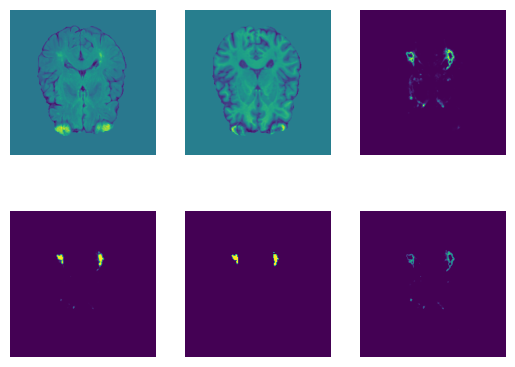

In [35]:
data = train_ds[50]
x = data[0][0]
mask = data[0][1]
#x, mask = transforms(x, mask)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x[i][30])
    plt.axis('off')

### formatting the data into input types to use and creating the dataloader

current data shape is ((x, mask, clin_values), label)

In [36]:
import torchvision as tv

class FormatDataset(Dataset):
    def __init__(self, base_dataset, slice_range=(25,45), centre_crop=(220,160), channels=['flair']):
        self.base_dataset = base_dataset
        self.slice_range = slice_range
        self.centre_crop = centre_crop
        self.channels = channels
        
    def __getitem__(self, idx):
        channels_id = {
            "flair":0,
            "t1":1,
            "ent":2,
            "pred":3,
            "seg":4,
            "var":5,
        }
        
        (x_3d, mask, clin_data), label = self.base_dataset[idx]
        
        # print(x_3d.shape)
        
        selected_channels = [channels_id[c] for c in self.channels]
        
        # Select the slices from the 3D image
        x_3d = x_3d[selected_channels]
        # print(x_3d.shape)
        
        slices = np.arange(self.slice_range[0], self.slice_range[1], 1)
        x_3d = x_3d[:, slices]
        # print(x_3d.shape)
        
        # Reshape the slices into C*v 2D tensors
        x_2d = torch.reshape(x_3d, (-1, x_3d.shape[-2], x_3d.shape[-1]))
        # x_2d = x_3d
        
        # print(x_2d.shape)
        
        x_2d = tv.transforms.functional.center_crop(x_2d, self.centre_crop)
        
        # print(x_2d.shape)
        
        return (x_2d, clin_data.astype(np.float32).squeeze()), label
        
    
    def __len__(self):
        return len(self.base_dataset)

In [37]:
channels = ['pred']
train_ds_2d = FormatDataset(train_ds, channels=channels)
val_ds_2d = FormatDataset(val_ds, channels=channels)
test_ds_2d = FormatDataset(test_ds, channels=channels)

In [38]:
val_ds_2d = ConcatDataset([val_ds_2d, test_ds_2d])
test_ds_2d = None

In [53]:
class GetLabelsDs(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        
    def __getitem__(self, idx):
        return self.base_dataset[idx]
    
    def __len__(self):
        return len(self.base_dataset)
    
    def get_labels(self):
        labels = []
        for (x, clin_data), y in self.base_dataset:
            labels.append(y)
            
        return labels

In [56]:
class ResampledDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        labels = [y for _, y in base_dataset]
        # print(labels)
        labels = np.array(labels)
        uniques = natsorted(np.unique(labels))

        label_counts = [np.sum(labels == label) for label in uniques]
        
        largest_group_size = max(label_counts)
            
        label_positions = {label:[] for label in uniques}

        for i, label in enumerate(labels):
            label_positions[label].append(i)
            
        #label_positions = {label:}
            
        resampled_indexes = []
        for label in uniques:
            count = 0
            i = 0
            while count < largest_group_size:
                label_pos = label_positions[label]
                label_total = len(label_pos)
                resampled_indexes.append(label_pos[i % label_total])
                i += 1
                count += 1
                
        self.resampled_indexes = resampled_indexes
        # print(resampled_indexes)
        
    def __getitem__(self, idx):
        return self.base_dataset[self.resampled_indexes[idx]]
    
    def __len__(self):
        return len(self.resampled_indexes)

In [57]:
batch_size = 12
# train_dataloader = DataLoader(train_ds_2d, batch_size=batch_size, shuffle=True, num_workers=4)
# val_dataloader = DataLoader(val_ds_2d, batch_size=batch_size, shuffle=False, num_workers=4)
# test_dataloader = DataLoader(test_ds_2d, batch_size=batch_size, shuffle=False, num_workers=4)
train_dataloader = DataLoader(train_ds_2d, batch_size=batch_size, sampler=ImbalancedDatasetSampler(GetLabelsDs(train_ds_2d)), num_workers=4)
# val_dataloader = DataLoader(val_ds_2d, batch_size=batch_size, sampler=ImbalancedDatasetSampler(val_ds_2d), num_workers=4)
val_dataloader = DataLoader(ResampledDataset(val_ds_2d), batch_size=batch_size, shuffle=False, num_workers=4)

In [58]:
val_ds_2d[0][0][1].astype(np.float32).squeeze()

array([-0.02500828,  0.66227365, -0.582079  ,  0.21757682, -1.0463433 ,
       -1.0485672 , -1.0964288 ,  0.39493522,  1.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
      dtype=float32)

In [59]:
#out = next(iter(test_dataloader))

### Setting up model for training

In [60]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        channel_size_divide=1,
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64//channel_size_divide
        self.init_inplanes = self.inplanes
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64//channel_size_divide, layers[0])
        self.layer2 = self._make_layer(block, 128//channel_size_divide, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256//channel_size_divide, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512//channel_size_divide, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        #x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights,#: Optional[WeightsEnum],
    progress: bool,
    channel_size_divide,
    **kwargs: Any,
) -> ResNet:
    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet(block, layers, channel_size_divide, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))

    return model

def resnet18(*, progress: bool = True, channel_size_divide=2, **kwargs: Any) -> ResNet:
    return _resnet(BasicBlock, [2, 2, 2, 2], None, progress, channel_size_divide=channel_size_divide, **kwargs)

def resnet34(*, progress: bool = True, **kwargs: Any) -> ResNet:

    return _resnet(BasicBlock, [3, 4, 6, 3], None, progress, **kwargs)

In [61]:
### selecting a model

class PredictionModel(torch.nn.Module):
    # uses a modified resnet that bypasses the usual 
    def __init__(self, image_channels, num_clin_features, out_classes, latent_fc_features=64, channel_size_divide=2):
        super().__init__()
        model_base = resnet18(channel_size_divide=channel_size_divide)
        self.channel_size_divide = channel_size_divide
        model_base.conv1 = nn.Conv2d(image_channels, model_base.init_inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.model_base = model_base
        
        # replace the head of the model with another layer.
        self.fc1 = nn.Linear(model_base.fc.in_features//channel_size_divide + num_clin_features, latent_fc_features)
        self.a = nn.ReLU()
        self.fc2 = nn.Linear(latent_fc_features, out_classes)
        
    def forward(self, inp):
        x = inp[0]
        clin_data = inp[1]
        
        # x = None
        
        if x != None:
            features = self.model_base(x)
        else:
            features = torch.zeros(inp[0].shape[0], 512//self.channel_size_divide).cuda()
        dense_input = torch.cat([features, clin_data], dim=1)
        
        out = self.fc2(self.a(self.fc1(dense_input)))
        
        return out
        
        

In [62]:
class xent_wrapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_loss = torch.nn.CrossEntropyLoss()
    def forward(self, y_hat, y):
        return self.base_loss(y_hat, y.type(torch.long))

In [63]:
def run_eval_2(mdl, dataloader):
    # reimplementing this, because my old code was behaving strangely....
    
    y_hats = []
    ys = []
    
    for (x, clin_data), y in dataloader:
        with torch.no_grad():
            mdl.eval()
            out = mdl.cuda()((x.cuda(), clin_data.cuda())).cpu()
            y_hat = out.argmax(dim=1)
            y_hats.append(y_hat)
            ys.append(y)
    
    y_hats = torch.cat(y_hats)
    ys = torch.cat(ys)
    
    print(ys.shape, y_hats.shape)
    
    mean_acc = (y_hats == ys).sum() / ys.shape[0]
    
    return mean_acc
            
    
    

In [64]:
val_results = []
eval_results = []
for i in range(1):
    image_channels = train_ds_2d[0][0][0].shape[0]
    clin_features = len(fields)
    model_raw = PredictionModel(image_channels=image_channels, num_clin_features=clin_features, out_classes=4, channel_size_divide=8)#.cuda()
    loss = xent_wrapper()
    
    ### training the model
    # setup optimizer and model wrapper

    weight_decay = 0.01#0.05
    max_epochs = 100
    lr=2e-4
    early_stop_patience = 7

    optimizer_params={"lr":lr, "weight_decay":weight_decay}
    optimizer = torch.optim.Adam
    lr_scheduler_params={"milestones":[1000], "gamma":0.5}
    lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

    # wrap the model in the pytorch_lightning module that automates training
    model = StandardLitModelWrapper(model_raw, loss, 
                                    logging_metric=lambda : None,
                                    optimizer_params=optimizer_params,
                                    lr_scheduler_params=lr_scheduler_params,
                                    optimizer_constructor=optimizer,
                                    lr_scheduler_constructor=lr_scheduler_constructor
                                   )

    # train the model
    trainer = get_trainer(max_epochs, "/disk/scratch_big/s2208943/example_pred_0/", early_stop_patience=early_stop_patience)
    
    trainer.fit(model, train_dataloader, val_dataloader)
    
    model_results = []
    for _ in range(3):
        result = trainer.validate(model, val_dataloader, ckpt_path='best')
#         model_results.append(result[0]['val_loss'])
        
#     val_results.append(torch.Tensor(model_results).mean())
#     print("val score: ", val_results[-1])
        
#     eval_stat = run_eval(model, test_dataloader)
#     print("eval stat: ", eval_stat)
#     eval_results.append(eval_stat)

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/lightning_lite/plugins/environments/slurm.py:167: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/s2208943/miniconda3/envs/uq/lib/python3.10/sit ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /disk/scratch_big/s2208943/example_pred_0 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | PredictionModel | 702 K 
1 | lo

Sanity Checking: 0it [00:00, ?it/s]

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.381


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.01. New best score: 1.356


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.128 >= min_delta = 0.01. New best score: 1.228


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.104 >= min_delta = 0.01. New best score: 1.124


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.01. New best score: 1.097


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.083 >= min_delta = 0.01. New best score: 1.014


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.01. New best score: 1.000


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.089 >= min_delta = 0.01. New best score: 0.911


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.01. New best score: 0.896


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.160 >= min_delta = 0.01. New best score: 0.736


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.736. Signaling Trainer to stop.
Restoring states from the checkpoint path at /disk/scratch_big/s2208943/example_pred_0/epoch=19-step=340.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /disk/scratch_big/s2208943/example_pred_0/epoch=19-step=340.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7268369197845459
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at /disk/scratch_big/s2208943/example_pred_0/epoch=19-step=340.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /disk/scratch_big/s2208943/example_pred_0/epoch=19-step=340.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7268369197845459
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at /disk/scratch_big/s2208943/example_pred_0/epoch=19-step=340.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /disk/scratch_big/s2208943/example_pred_0/epoch=19-step=340.ckpt


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7268369197845459
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [65]:
# check checkpoint changes, (this folder, target, split, run
# switch to doing eval on train val and test.
# plot a batch of the dataset, middle slice

In [66]:
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7268369197845459
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.7268369197845459}]

In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def plot_confusion_matrix(dataloader, model):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for (x, clin_data), labels in tqdm(dataloader, position=0, leave=True):
            outputs = model.cuda()((x.cuda(), clin_data.cuda()))
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    num_classes = cm.shape[0]
    class_names = [str(i) for i in range(num_classes)]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    
    for i in range(num_classes):
        for j in range(num_classes):
            text = ax.text(j, i, np.round(cm[i, j], 3),
                           ha="center", va="center", color="black")
            text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

    
    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()

    #return all_preds, all_labels

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.42s/it]


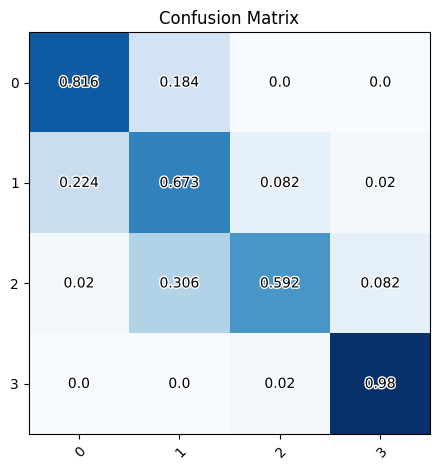

In [68]:
# rebalanced dataset
plot_confusion_matrix(val_dataloader, model)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.13it/s]


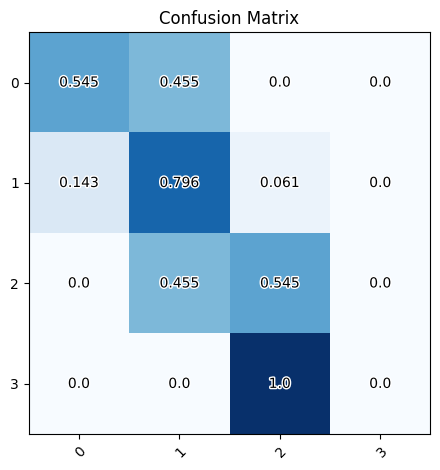

In [51]:
plot_confusion_matrix(val_dataloader, model)

In [74]:
# new run
run_eval_2(model, test_dataloader)

torch.Size([42]) torch.Size([42])


tensor(0.7619)

In [75]:
run_eval_2(model, val_dataloader)

torch.Size([41]) torch.Size([41])


tensor(0.6585)

In [76]:
run_eval_2(model, train_dataloader)

torch.Size([193]) torch.Size([193])


tensor(0.7461)

In [54]:
run_eval(model, train_dataloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:08<00:00, 34.17s/it]

torch.Size([2, 193])


(tensor(0.3679), tensor(0.8578), tensor(0.9877))

In [66]:
batch = next(iter(train_dataloader))

In [67]:
len(batch)

2

In [68]:
batch[0][0].shape

torch.Size([12, 20, 220, 160])

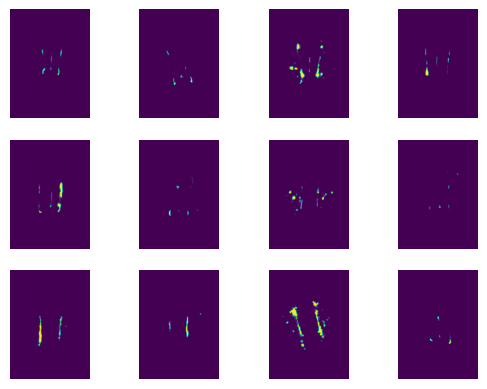

In [69]:
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(batch[0][0][i][10]); plt.axis('off')

In [310]:
# new run
run_eval(model, test_dataloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.98s/it]

torch.Size([2, 42])


(tensor(0.7619), tensor(0.7500), tensor(1.))

In [311]:
run_eval(model, val_dataloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.78s/it]

torch.Size([2, 41])


(tensor(0.7317), tensor(0.7708), tensor(0.9792))

In [312]:
run_eval(model, train_dataloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:45<00:00, 22.98s/it]

torch.Size([2, 193])


(tensor(0.4197), tensor(0.8627), tensor(0.9877))

In [307]:
run_eval(model, test_dataloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.04s/it]

torch.Size([2, 42])


(tensor(0.8095), tensor(0.7917), tensor(1.))

In [261]:
run_eval(model, test_dataloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.85s/it]

torch.Size([2, 42])


(tensor(0.8095), tensor(0.8125), tensor(1.))

In [ ]:
# with smaller model, higher weight decay, we got 0.8 in 7 epochs.
# lets try again. I could try training the same model, where I just finetune the fc layers afterwards.
# again: 0.76
# again 0.71. eugh it is so variable.

# when i just train with the clinical scores, it goes on for 50 epochs.
# so there is useful information there, that I am perhaps loosing when I get a model
# that trains in 7 epochs on the umap. I need to be careful with that and reduce the number of output features
# that the model gives perhaps.
# when it did that training, it got to 0.57 accuracy when it had no umaps.


# so: things I can try to get more consistency:
# 1) add more weight decay.
# 2) reduce the model parameters
# 3) go from two fc layers to one.

In [300]:
for (x, clin_data), label in train_dataloader:
    with torch.no_grad():
        outs = model.cuda()((x.cuda(), clin_data.cuda())).cpu()
        outs = torch.nn.functional.softmax(outs, dim=1).argmax(dim=1)
        print(outs.shape)
    
    print((outs == label).sum() / len(label))
    print(outs.type(torch.float32))
    print(label)

torch.Size([12])
tensor(0.8333)
tensor([1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1.])
tensor([1., 1., 0., 1., 2., 1., 1., 1., 2., 1., 1., 2.], dtype=torch.float64)
torch.Size([12])
tensor(0.6667)
tensor([1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 2., 1., 1., 1., 0., 1., 0., 1., 2., 1., 0.], dtype=torch.float64)
torch.Size([12])
tensor(0.4167)
tensor([1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2.])
tensor([2., 1., 1., 0., 1., 1., 1., 1., 0., 0., 2., 1.], dtype=torch.float64)
torch.Size([12])
tensor(0.5000)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 0., 1., 2., 1., 1., 1., 3., 0., 1., 1., 0.], dtype=torch.float64)
torch.Size([12])
tensor(0.5000)
tensor([2., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.])
tensor([2., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.], dtype=torch.float64)
torch.Size([12])
tensor(0.5833)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=torch.float64